<a href="https://colab.research.google.com/github/rajaonsonella/crosstalk-q2-2025/blob/main/notebooks/1_0_Molecule_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecule features

This notebook explores molecular features and representations using Delaney’s solubility dataset. We’ll use cheminformatics tools to compute molecular descriptors and fingerprints, visualize chemical space with dimensionality reduction (PCA, UMAP), and identify structural clusters. The workflow demonstrates how to transform molecular structures into numerical features suitable for machine learning and data analysis in drug discovery.

### Installation of Required Libraries

In [ ]:
!pip install rdkit
!pip install umap-learn
!pip install hdbscan

### Importing Libraries and Modules

In [ ]:
import io
import random
import itertools
# tqdm for a progress bar
from tqdm.auto import tqdm
# scientific python stack
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import scipy.spatial.distance as sp_dist
import altair as alt
# ML libraries
import sklearn
import sklearn.decomposition
import umap
import hdbscan
# Chemo-informatics
import rdkit
import rdkit.Chem.Descriptors
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
# Jupyter/IPython libraries
import IPython.display as ipy_display
from IPython.display import Image, display
import base64
import PIL

def html_header(astr, n):
    display(ipy_display.HTML(f'<h{n}>{astr}</h{n}>'))

for mod in [np, sp, rdkit]:
    print(f'{mod.__name__:20s}:{mod.__version__}')

# Sample dataset, solubility (logP) 💧

Datatset source: Delaney's solubility dataset from ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure
(https://pubs.acs.org/doi/10.1021/ci034243x)

We'll be using a well-known dataset for predicting the solubility of molecules. This dataset is a classic in cheminformatics and is readily available. It is a regression task.

The task is: Given a molecule, predict its aqueous solubility (logP).

### Let's download the dataset with wget


In [ ]:
!wget -nc https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

In [ ]:
df = pd.read_csv('delaney-processed.csv')
target = 'measured log solubility in mols per litre'
print(df.shape)
df.head()

# Molecule features
This section demonstrates how to access and visualize information about a single, randomly-selected molecule from the dataset.

Let's pick a random row

In [ ]:
row = df.sample().iloc[0]
ipy_display.display(row)
smi = str(row['smiles'])
mol = Chem.MolFromSmiles(smi)
mol

And we can convert them from molecules to smiles!

In [ ]:
new_smi = Chem.MolToSmiles(mol)
print(smi)
print(new_smi)

Let's use apply to create a new column of molecules.

This is a key step for working with RDKit.  We're going to create a new column called 'mol' in our DataFrame.  This column will store the RDKit molecule objects, making it easy to apply RDKit functions to all molecules in the dataset.

In [ ]:
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df[['mol']].head()

## How do we convert molecules into numbers?

Now we'll start calculating numerical descriptors from our molecule objects.  These descriptors quantify various aspects of the molecular structure and are used as input features for machine learning models.

Calculates the molecular weight of the molecule.

In [ ]:
mol_weight = Descriptors.MolWt(mol)
mol_weight

Calculates the estimated octanol-water partition coefficient (logP), a measure of lipophilicity (how well the molecule dissolves in fats).  This is a common descriptor used in drug discovery.

In [ ]:
crippen_logp = Descriptors.MolLogP(mol)
crippen_logp

## Molecular fingerprints

Molecular fingerprints are computational representations of molecules that encode chemical features of a molecule in the form of a binary digit (1 if present, 0 if not) or integer (how many are present). There are multiple ways of designing fingerprints.


## Molecular ACCess System (MACCS) fingerprints

Also termed MACCS structural keys, they consist of 166 predefined structural fragments. Each position queries the presence or absence of one particular structural fragment or key. The individual keys were empirically defined by medicinal chemists and are simple to use and interpret [1]

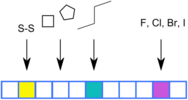


You can find the exact definitions of them here:

<https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/MACCSkeys.py>

For example rule 145 defines a 6-member ring:

```
  145: ('*1~*~*~*~*~*~1', 1),  # 6M ring > 1
```


## Morgan fingerprints

They are based on the Morgan algorithm. The bits correspond to the circular environments of each atom in a molecule. The number of neighboring bonds and atoms to consider is set by the radius. Also the length of the bit string can be defined, a longer bit string will be modded to the desired length. Therefore, the Morgan fingerprint is not limited to a certain number of bits.

## Extended connectivity fingerprints (ECFP)

 are also commonly used fingerprints that are derived using a variant of the Morgan algorithm, see [J. Chem. Inf. Model. (2010), 50,742-754](https://pubs.acs.org/doi/full/10.1021/ci100050t) for further information.


[1]: [Talktorial 004 Volkamer](https://projects.volkamerlab.org/teachopencadd/talktorials/T004_compound_similarity.html)

[2]: [Chembook ECFP Blogpost](https://chemicbook.com/2021/03/25/a-beginners-guide-for-understanding-extended-connectivity-fingerprints.html)



Initializing the Morgan Fingerprint Generator

In [ ]:
# initialize Morgan Fingerprint generator
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)

# get the fingerprint of our RDKit mol object
fp = mfpgen.GetFingerprint(mol)

# Notice fp is a numpy array yet!!
print(type(fp))
ecfp4 = np.array(fp) # fp.ToList() also gives us a list.

print(ecfp4.shape)
print(ecfp4)

## How do we build a FP?
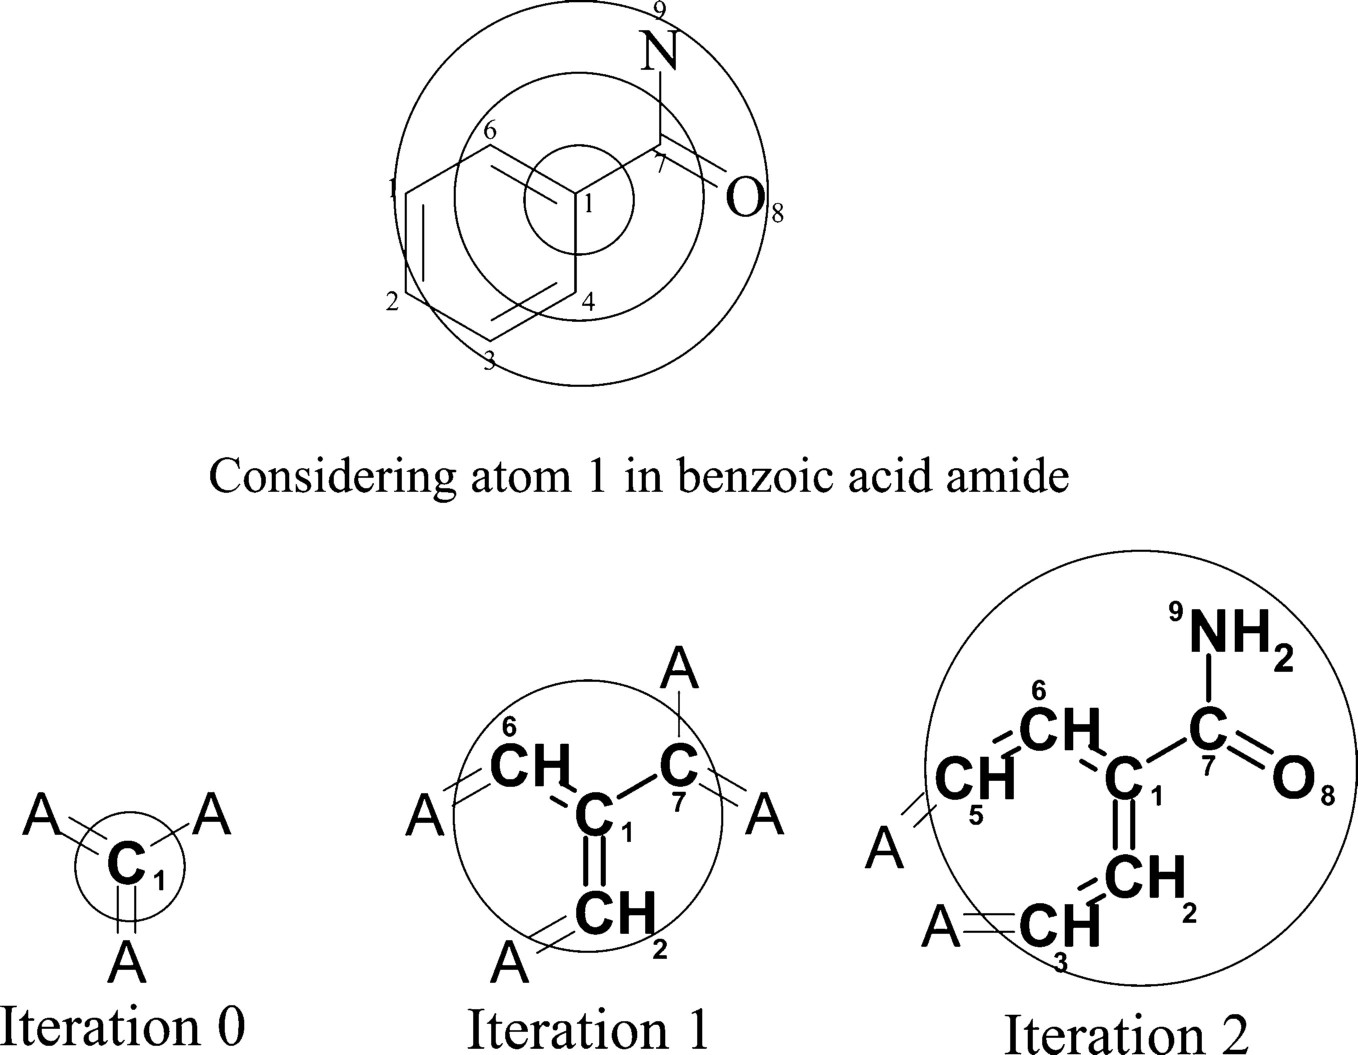

This code shows how to generate a fingerprint for a single molecule (`mol`, which we defined earlier) and inspect the result.

In [ ]:
mols = df['mol'].tolist()
fps = np.stack([mfpgen.GetFingerprint(m) for m in mols])
print(fps.shape)

This code demonstrates how to calculate the Jaccard distance between two randomly selected molecules using their fingerprints. The Jaccard distance is a measure of dissimilarity between sets (in this case, sets of fingerprint bits).

In [ ]:
n = fps.shape[0]
index1, index2 = random.sample(range(n), 2)
mols_to_display = [mols[index1], mols[index2]]
jaccard_dist = sp_dist.jaccard(fps[index1], fps[index2])
img = Draw.MolsToGridImage(mols_to_display, molsPerRow=2, subImgSize=(200, 200),
                      legends=[f"Molecule {index1}", f"Molecule {index2}"], useSVG=True)
display(img)
html_header(f'Distance: {jaccard_dist:.4f}', 2)


### Calculating and Visualizing Pairwise Jaccard Distances

This code calculates the Jaccard distance between *all* pairs of molecules in the dataset and visualizes the results as a heatmap and a distribution plot. This gives us a global view of the structural similarity within the dataset.

In [ ]:
distance_matrix = np.zeros((n, n))
pbar = tqdm(itertools.combinations(range(n), 2), total=n * (n - 1) // 2)
for (i, j) in pbar:
    jaccard_dist = sp_dist.jaccard(fps[i], fps[j])
    distance_matrix[i, j] = distance_matrix[j, i] = jaccard_dist
plt.figure(figsize=(8, 7))
sns.heatmap(distance_matrix, cmap="viridis", square=True, xticklabels=False, yticklabels=False)
plt.title("Pairwise Jaccard Distance Matrix")
plt.show()
distances = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
plt.figure(figsize=(8, 5))
sns.histplot(distances, bins=30, kde=True)
plt.title("Distribution of Pairwise Jaccard Distances")
plt.show()

## PCA & UMAP visualization

We now have high-dimensional fingerprint data (2048 dimensions).  It's difficult to visualize data in such high dimensions.  Here, we'll use two dimensionality reduction techniques, PCA and UMAP, to project the data down to two dimensions for visualization.


A great resource to check out how to use UMAP responsably:
* https://umap-learn.readthedocs.io/en/latest/plotting.html
* https://pair-code.github.io/understanding-umap/


In [ ]:
pca_pipeline = sklearn.pipeline.Pipeline([
    ('scaler', sklearn.preprocessing.StandardScaler()),
     ('pca', sklearn.decomposition.PCA(n_components=2))])
pca_components = pca_pipeline.fit_transform(fps)
plt.figure(figsize=(8, 7))
plt.scatter(pca_components[:, 0], pca_components[:, 1], s=1)
plt.title('PCA of Molecular Fingerprints (Normalized)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

umap_pipeline = sklearn.pipeline.Pipeline([
     ('umap', umap.UMAP(n_components=2, metric='jaccard',
                        n_neighbors=20,
                        min_dist=0.1))])
umap_components = umap_pipeline.fit_transform(fps)
plt.figure(figsize=(8, 7))
plt.scatter(umap_components[:, 0], umap_components[:, 1], s=1)
plt.title('UMAP of Molecular Fingerprints (Jaccard)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

## Clustering with HDBSCAN

Now we'll use HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) to find clusters of molecules with similar fingerprints. HDBSCAN is a density-based clustering algorithm, meaning it identifies clusters as areas of high density separated by areas of low density.  It's particularly useful for finding clusters of varying shapes and sizes and doesn't require specifying the number of clusters beforehand.

* https://hdbscan.readthedocs.io/en/latest/index.html
* https://pberba.github.io/stats/2020/01/17/hdbscan/

In [ ]:
hdbscan_clusterer = hdbscan.HDBSCAN(
                                    min_cluster_size=13)
umap_pipeline = sklearn.pipeline.Pipeline([
    ('umap',  umap.UMAP(n_components=2, metric='jaccard',
                        n_neighbors=20,
                        min_dist=0.1))])
umap_components = umap_pipeline.fit_transform(fps)
clusters = hdbscan_clusterer.fit_predict(umap_components)

unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters[unique_clusters != -1]) # Exclude noise cluster -1
html_header(f"Number of clusters found by HDBSCAN: {num_clusters}",1)

plt.figure(figsize=(8, 7))
scatter = plt.scatter(umap_components[:, 0], umap_components[:, 1], c=clusters, cmap='Set3', s=5)
plt.title('UMAP of Molecular Fingerprints Colored by HDBSCAN Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

colorbar = plt.colorbar(scatter, ticks=unique_clusters)
colorbar.set_label('Cluster')
colorbar.ax.set_yticklabels([int(c) if c != -1 else 'Noise' for c in unique_clusters]) # Ensure integer labels

plt.show()

# Now let's add the labels to the mix

In [ ]:
y = df[target].values.reshape(-1,1)
print(y.shape)
sns.displot(y)
plt.xlabel(target)
plt.show()

This code repeats the UMAP visualization, but this time, the points are colored by their *solubility* values (instead of cluster assignments).  This allows us to see if there's a relationship between the UMAP projection and the target variable.

In [ ]:
umap_pipeline = sklearn.pipeline.Pipeline([
     ('umap', umap.UMAP(n_components=2, metric='jaccard',
                        n_neighbors=20,
                        min_dist=0.1))])
umap_components = umap_pipeline.fit_transform(fps)
plt.figure(figsize=(8, 7))
plt.scatter(umap_components[:, 0], umap_components[:, 1],  c=y,
            cmap='viridis', s=5)
plt.title('UMAP of Molecular Fingerprints (Jaccard)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

# Interactive Visualization with Altair

This section uses the Altair library to create an interactive visualization.  The visualization will show the UMAP projection, and when you hover over a point, it will display the 2D structure of the corresponding molecule.


In [ ]:

# Round-trip encode image to base64, see if PIL reads base64 and produces same image.
def encode_image_as_base64(img):
  """Encode image to base64 strings, useful to embed images in HTML/js."""
  buffer = io.BytesIO()
  img.save(buffer,format="PNG")
  encoded_string = "data:image/png;base64,"+base64.b64encode(buffer.getvalue()).decode()
  return encoded_string

def encode_mols_as_base64(mols, img_size:int=128):
  """Encode molecule images as base64 strings, useful to embed images."""
  img_list = [Draw.MolToImage(m, size=(img_size, img_size)) for m in mols]
  return [encode_image_as_base64(img) for img in img_list]


IMG_SIZE = 128
img_col = 'img2'

vis_df = pd.DataFrame({
    "x": umap_components[:, 0],
    "y": umap_components[:, 1],
     'logP': y.flatten(),
    'SMILES': df['smiles'],
    'molecule_index': range(len(umap_components))})
vis_df[img_col] = encode_mols_as_base64(mols, IMG_SIZE)

mouseover = alt.selection_single(on="mouseover", nearest=True, fields=['x', 'y'], empty="none")

base = alt.Chart(vis_df).mark_circle(size=6).encode(
    x='x',
    y='y',
    color=alt.Color('logP:Q', scale=alt.Scale(scheme='viridis')),  # Color by logP
    tooltip=['molecule_index', 'SMILES', 'logP'] # Add tooltips!
).add_selection(mouseover)

img = base.mark_image().encode(
    x=alt.X('x', axis=None),
    y=alt.Y('y', axis=None),
    url=img_col).properties(width=IMG_SIZE, height=IMG_SIZE)
img = img.transform_filter(mouseover)
combined_chart = base.interactive() | img
combined_chart